# Transfer Learning
---
## 쉽지만 중요한 코너!

**잘 만들어진** 모델들을 가져다가 **고쳐** 사용해보자.

* [모델들은 이 링크를 참고해보자](https://keras.io/applications/)
* [트랜스퍼 러닝?](https://miro.medium.com/max/2800/1*D5S6ylZwUZAxj0lMyipZ2g.png)

![transfer](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/05/31112715/finetune1.jpg)


- 이걸 하는 목적 : 클래스가 3개인 것을 내 입맛대로 고쳐쓰기 위해서
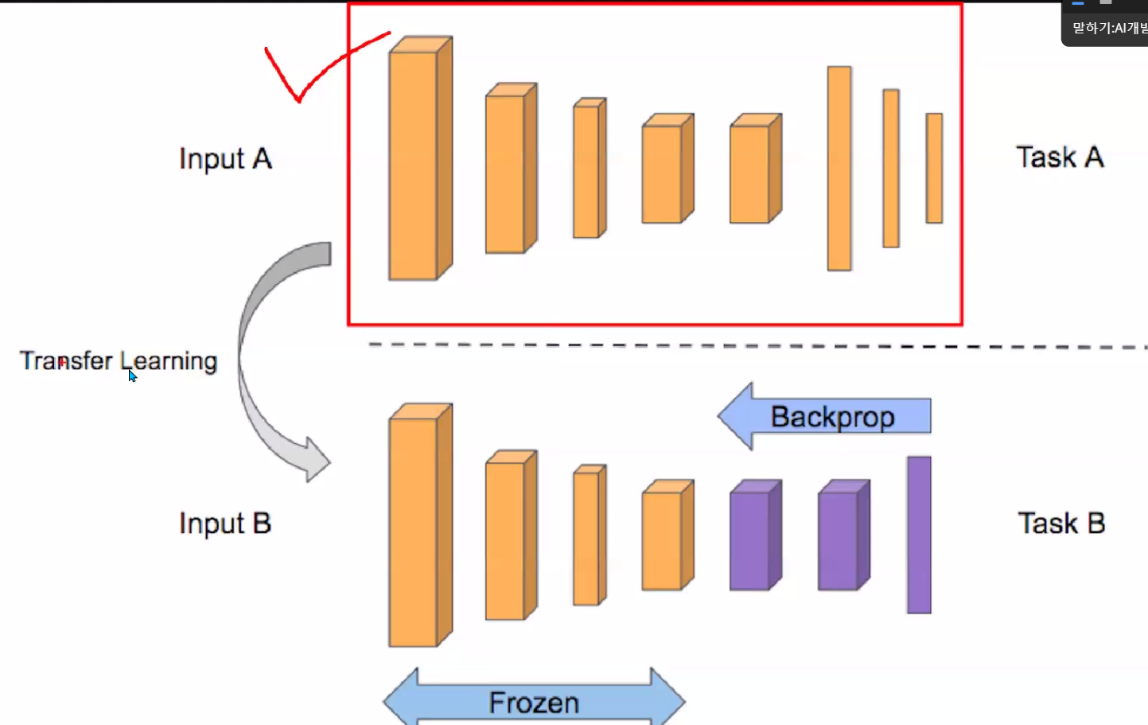

## 라이브러리 로딩

In [1]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.inception_v3 import decode_predictions
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

from sklearn.model_selection import train_test_split

import random
import numpy as np
import matplotlib.pyplot as plt
import glob

## 데이터 수집합시다!

* 최소 조건 : 클래스 3개, 한 클래스당 10장 이상. **다다익선!**
    * image-net data에는 확실히 없을만한 것들로.
    * **좋은 결과**를 위해서라면 확실히 차이나는 것들로.
    * **도전(역경)**을 위해서라면 클래스가 달라도 비슷비슷 한걸로.
---
* **본인의** 구글 드라이브 my_data 폴더에 클래스당 각각 폴더를 만들어서 업로드.
- **상세 설명**
    1. my_data 폴더를 **본인의** 구글 드라이브 바로 아래에 만들어둔다.
    2. my_data 폴더 안에 transfer 폴더를 만든다.
    3. transfer 폴더 안에 이미지들을 수집하고, 하나의 클래스당 하나의 폴더를 갖도록 정리/업로드한다.
    4. 5초 정도 여유를 갖자.
    5. 아래 코드들을 실행한다

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
!cd /content/drive/MyDrive/my_data/; ls

img1  img2  model.png  my_mnist  transfer


In [13]:
# mkdir /content/drive/MyDrive/my_data/transfer/

In [14]:
files = glob.glob('/content/drive/MyDrive/my_data/transfer/*/*')
files

['/content/drive/MyDrive/my_data/transfer/shine_hair/온천주호민.jpg',
 '/content/drive/MyDrive/my_data/transfer/shine_hair/한석원쌤.jpg',
 '/content/drive/MyDrive/my_data/transfer/shine_hair/대머리수학쌤.jpg',
 '/content/drive/MyDrive/my_data/transfer/shine_hair/계란후라이.jpg',
 '/content/drive/MyDrive/my_data/transfer/shine_hair/사람얼굴.jpg',
 '/content/drive/MyDrive/my_data/transfer/shine_hair/abcf226ff8295aa145cf631e693e4f48.jpg',
 '/content/drive/MyDrive/my_data/transfer/shine_hair/85c7b567b28330e3d605a115a45ed0c0.jpg',
 '/content/drive/MyDrive/my_data/transfer/shine_hair/6a98283e4bc8b5a4857abb7004d56f79.jpg',
 '/content/drive/MyDrive/my_data/transfer/shine_hair/22921f2ee3b4420ced1fc88e31e30007.jpg',
 '/content/drive/MyDrive/my_data/transfer/shine_hair/5a7958f54d545132e28cbcc2bd74d5fe.jpg',
 '/content/drive/MyDrive/my_data/transfer/bread/0e90cda6b769dc671725b9455ec426db.jpg',
 '/content/drive/MyDrive/my_data/transfer/bread/89f4cc52096805600ffcb51df24ba870.jpg',
 '/co

In [15]:
name_cnt = {}

for x in files :
    name_cnt[x.split('/')[-2]] = name_cnt.get(x.split('/')[-2], 0) + 1

name_cnt

{'shine_hair': 10, 'bread': 15, 'long_hair': 10}

In [16]:
i = 0
names = {}

for key in name_cnt :
    names[key] = i     # names_cnt의 key값에 새로운 값 부여
    i += 1             # 클래스 수만큼 i값 증가

names

{'shine_hair': 0, 'bread': 1, 'long_hair': 2}

In [17]:
images = []
labels = []

for path in files:
    img = image.load_img(path, target_size=(299,299) )
    img = image.img_to_array(img)
    
    images.append(img)
    labels.append(names[path.split('/')[-2]])
    
    plt.imshow(image.load_img(path))
    plt.show()

images_arr = np.array(images)
labels_arr = np.array(labels)

print(images_arr.shape)
print(labels_arr.shape)

Output hidden; open in https://colab.research.google.com to view.

In [18]:
print(labels_arr)
label_v = len(np.unique(labels_arr))
label_v

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]


3

In [19]:
### 라벨링
y = to_categorical(labels, label_v)

In [20]:
print(y[:3])
y.shape

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


(35, 3)

## 데이터를 나누자, train-valid-test

- 각 이미지 그룹별로 균등한 분할을 위하여. 아래 코드가 조금 복잡하다.

In [21]:
temp = []
init_v = 0

for v in name_cnt.values() :
    temp.append( (images[init_v:init_v+v], y[init_v:init_v+v]) )
    init_v += v

In [22]:
for i in range(len(temp)) :
    x_to_array = np.array(temp[i][0])
    y_to_array = np.array(temp[i][1])

    train_x, test_x, train_y, test_y =\
        train_test_split(x_to_array, y_to_array, test_size=0.2, random_state=2023)
    
    train_x, valid_x, train_y, valid_y =\
        train_test_split(train_x, train_y, test_size=0.2, random_state=2023)

    if i==0 :
        first_tr_x, first_va_x, first_te_x = train_x.copy(), valid_x.copy(), test_x.copy()
        first_tr_y, first_va_y, first_te_y = train_y.copy(), valid_y.copy(), test_y.copy()

    elif i==1 :
        new_tr_x, new_tr_y = np.vstack((first_tr_x, train_x)), np.vstack((first_tr_y, train_y))
        new_va_x, new_va_y = np.vstack((first_va_x, valid_x)), np.vstack((first_va_y, valid_y))
        new_te_x, new_te_y = np.vstack((first_te_x, test_x)), np.vstack((first_te_y, test_y))

    else :
        new_tr_x, new_tr_y = np.vstack((new_tr_x, train_x)), np.vstack((new_tr_y, train_y))
        new_va_x, new_va_y = np.vstack((new_va_x, valid_x)), np.vstack((new_va_y, valid_y))
        new_te_x, new_te_y = np.vstack((new_te_x, test_x)), np.vstack((new_te_y, test_y))

In [23]:
new_tr_x.shape, new_tr_y.shape, new_va_x.shape, new_va_y.shape, new_te_x.shape, new_te_y.shape

((21, 299, 299, 3),
 (21, 3),
 (7, 299, 299, 3),
 (7, 3),
 (7, 299, 299, 3),
 (7, 3))

In [24]:
# 전처리 하지 않은 파일 따로 시각화 해두기
train_xv, valid_xv, test_xv = train_x.copy(), valid_x.copy(), test_x.copy()

In [25]:
new_tr_x.max(), new_tr_x.min()

(255.0, 0.0)

In [26]:
new_tr_x = preprocess_input(new_tr_x)
new_va_x = preprocess_input(new_va_x)
new_te_x = preprocess_input(new_te_x)

In [27]:
new_tr_x.max(), new_tr_x.min()

(1.0, -1.0)

## 인셉션! 남의 모델 불러오자!

In [28]:
keras.backend.clear_session()

base_model = InceptionV3(weights='imagenet',       # 이미지넷 데이터 바탕으로 미리 학습된 것
                         include_top=False,        # 마지막 레이어 빼고!
                         input_shape= (299,299,3)) # 입력 데이터의 형태

new_output = GlobalAveragePooling2D()(base_model.output)
new_output = Dense(3, # class 3개   클래스 개수만큼 진행한다.
                  activation = 'softmax')(new_output)

model = keras.models.Model(base_model.inputs, new_output)

model.summary()

87910968/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                  

In [29]:
print(f'모델의 레이어 수 : {len(model.layers)}')

모델의 레이어 수 : 313


## 이어서 학습시킬 레이어와, 고정시킬 레이어를 결정하자

In [30]:
len(model.layers)

313

In [31]:
for idx, layer in enumerate(model.layers) :
    if idx < 213 :
        layer.trainable = False
    else :
        layer.trainable = True

In [32]:
# 처음부터 학습시키는 것도 아니고,
# 마지막 100개만 튜닝 할 것이므로 learning rate를 조금 크게 잡아본다.

model.compile(loss='categorical_crossentropy', metrics=['accuracy'],
             optimizer=keras.optimizers.Adam(lr=0.001) )

## Data Augmentation & Callbacks

In [33]:
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                 patience=4,
                                 verbose=1,
                                 factor=0.5,
                                 min_lr=0.000001)

es = EarlyStopping(monitor='val_loss',
                   min_delta=0, # 개선되고 있다고 판단하기 위한 최소 변화량
                   patience=15, # 개선 없는 epoch 얼마나 기달려 줄거야
                   verbose=1,
                   restore_best_weights=True)

In [34]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=180, # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.3, # Randomly zoom image 
    width_shift_range=0.3,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.3,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True)  # randomly flip images

datagen.fit(train_x)

## 학습 시켜본다!!

In [35]:
# 데이터를 넣어서 학습시키자!
hist = model.fit(datagen.flow(train_x, train_y),
                 epochs=1000, validation_data=(valid_x, valid_y),
                 verbose=1, callbacks=[es, lr_reduction] )

Epoch 1/1000
1/1 [==============================] - 28s 28s/step - loss: 1.2470 - accuracy: 0.1667 - val_loss: 18.0778 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/1000
1/1 [==============================] - 0s 364ms/step - loss: 0.4325 - accuracy: 1.0000 - val_loss: 5.8320 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/1000
1/1 [==============================] - 0s 221ms/step - loss: 0.3099 - accuracy: 0.8333 - val_loss: 10.8437 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/1000
1/1 [==============================] - 0s 213ms/step - loss: 0.1589 - accuracy: 1.0000 - val_loss: 10.6692 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/1000
1/1 [==============================] - 0s 366ms/step - loss: 0.2132 - accuracy: 1.0000 - val_loss: 2.5617 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 6/1000
1/1 [==============================] - 0s 385ms/step - loss: 0.0116 - accuracy: 1.0000 - val_loss: 0.0726 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 7/1000
1/1 [==============================

## 결과를 본다!!

In [36]:
model.evaluate(test_x, test_y) ## [loss, accuracy]

1/1 [==============================] - 0s 51ms/step - loss: 0.0000e+00 - accuracy: 1.0000


[0.0, 1.0]

In [37]:
y_pred = model.predict(test_x)
y_pred

1/1 [==============================] - 1s 1s/step


array([[1.1434674e-12, 3.7906347e-25, 1.0000000e+00],
       [1.3444044e-09, 3.5139724e-17, 1.0000000e+00]], dtype=float32)

In [38]:
to_names = { v:k for k,v in names.items() }

------------------------------------------------------
실제 정답 : long_hair vs 모델의 예측 : long_hair 
shine_hair : 0.00%  bread : 0.00%  long_hair : 100.00%  


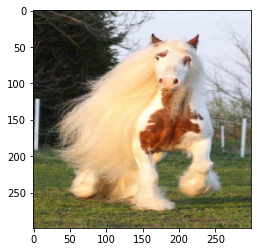

------------------------------------------------------
실제 정답 : long_hair vs 모델의 예측 : long_hair 
shine_hair : 0.00%  bread : 0.00%  long_hair : 100.00%  


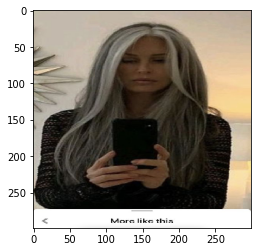

In [39]:
for i in range(len(test_x)) :
    print('------------------------------------------------------')
    print(f'실제 정답 : {to_names[test_y[i].argmax()]} vs 모델의 예측 : {to_names[y_pred[i].argmax()]} ')
    prob = ''
    
    for j in to_names :
        string = f'{to_names[j]} : {y_pred[i][j]*100:.2f}%  '
        prob = prob + string
    print(prob)
    plt.imshow(test_xv[i].reshape([299,299,3])/255)
    plt.show()